In [66]:
# !pip install tensorflow
# !pip install -U LibRecommender
# !pip install torch torchvision

In [12]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

import implicit
from implicit.als import AlternatingLeastSquares
import scipy.sparse as sparse
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import implicit.evaluation
from sklearn.model_selection import train_test_split

import tensorflow as tf
from libreco.algorithms import ALS
from libreco.data import random_split
from libreco.data import DatasetPure
from libreco.evaluation import evaluate

import tqdm as notebook_tqdm

# Wczytanie zbioru danych

In [13]:
interactions = pd.read_csv('interactions.csv')

# Wybór 10 % uzytkownikow

In [14]:
unique_users = interactions['user'].unique()

np.random.seed(42)
random_users = np.random.choice(unique_users, int(0.03 * len(unique_users)))

interactions = interactions.query('user in @random_users').copy()

In [15]:
interactions.shape

(1938983, 4)

# Wybór najistotniejszych itemów oraz userów

In [16]:
# posortowana ilosc wystapien kazdego itemu
item_counts = interactions['item'].value_counts().sort_values(ascending=False).copy()

# indeksy najczesciej wystepujacych itemow
sel_items = item_counts.head(int(0.2 * len(item_counts))).index

# filtrowanie po itemach
df_filtered_items = interactions.query('item in @sel_items').copy()

In [17]:
# posrotowana ilosc interakcji odpowiadajacych uzytkownikom
users_interactions_ = df_filtered_items.groupby('user').size().sort_values(ascending=False).copy()

# indeksy uzytkownikow z najwieksza liczba interakcji
sel_users = users_interactions_.head(int(0.2 * len(users_interactions_))).index

# df z wybranymi itemami i userami
df_filtered = df_filtered_items.query('user in @sel_users').copy()

# Usunięcie outlierów

In [18]:
def compute_quantiles(series, quantiles=np.arange(0.01, 1.01, 0.03)):
    return pd.DataFrame(
        [[quantile, series.quantile(quantile)] for quantile in quantiles],
        columns=["quantile", "value"],
    )

In [19]:
interactions_per_user = df_filtered.groupby("user").size()

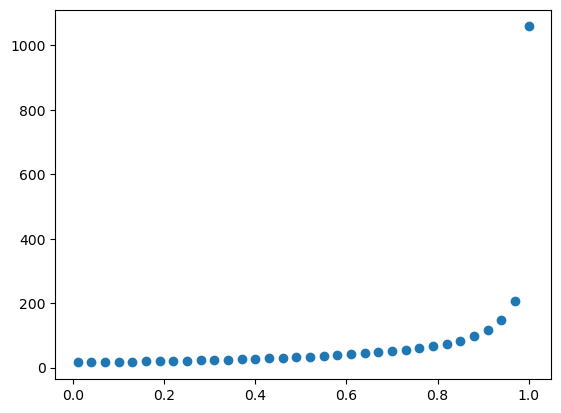

In [20]:
interaction_per_user_quantiles = compute_quantiles(interactions_per_user)
plt.scatter(interaction_per_user_quantiles['quantile'], interaction_per_user_quantiles['value'])
plt.show()

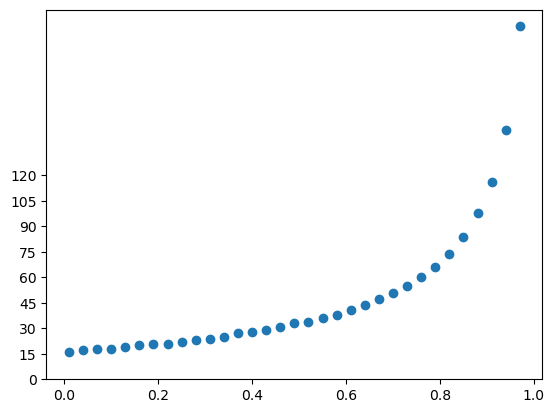

In [21]:
# Wykres po usunieciu ostatniej obs
plt.scatter(interaction_per_user_quantiles['quantile'][:-1], interaction_per_user_quantiles['value'][:-1])
plt.yticks(range(0, 121, 15))
plt.show()

In [22]:
upper_limit = interactions_per_user.quantile(0.965)  # z maksymalnie 210 interakcjami - do ustalenia

filtered_int_per_us = interactions_per_user[interactions_per_user <= upper_limit]

In [23]:
selected_users = [user for user in filtered_int_per_us.index]
df = df_filtered.query('user in @selected_users')

## Usunięcie outlierów z itemów

In [24]:
interactions_per_item = df.groupby("item").size()

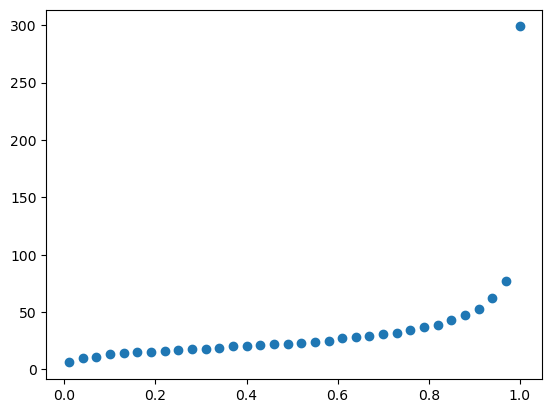

In [25]:
interaction_per_item_quantiles = compute_quantiles(interactions_per_item)
plt.scatter(interaction_per_item_quantiles['quantile'], interaction_per_item_quantiles['value'])
plt.show()

In [26]:
print(interactions_per_item.quantile(0.1))
print(interactions_per_item.quantile(0.999999999))

13.0
298.9999755120007


In [27]:
lower_limit = interactions_per_item.quantile(0.1)  # wybieramy itemy z co najmniej 9 wystąpieniami
upper_limit = interactions_per_item.quantile(0.999999999) # z maksymalnie 72 wystąpieniami - do ustalenia

filtered_int_per_item = interactions_per_item[(interactions_per_item >= lower_limit) & (interactions_per_item <= upper_limit)]

In [28]:
selected_items = [item for item in filtered_int_per_item.index]
df1 = df.query('item in @selected_items') # df1 - df z wybranymi uzytkownikami i itemami po usunieciu outlierow

In [29]:
df1 # przetworzony zb danych

,user,item,event,timestamp
59,868731,79507,click,1581465601
69,1176681,184065,click,1581465601
162,3104712,125545,click,1581465602
220,854565,2237,click,1581465604
251,199212,61521,click,1581465605
...,...,...,...,...
65501734,1179282,63423,click,1582675189
65501774,698617,36803,click,1582675190
65502034,644727,121409,click,1582675196
65502043,1193116,183817,chat_click,1582675196


In [30]:
df1.item.value_counts().min()

13

## Podstawowe statystyki zbioru

In [31]:
n_users = df1["user"].nunique()
n_items = df1["item"].nunique()
n_interactions = df1.shape[0]

interactions_per_user = df1.groupby("user").size()
interactions_per_item = df1.groupby("item").size()

print(f"We have {n_users} users, {n_items} items and {n_interactions} interactions.")
print(f"Data sparsity (% of missing entries) is {100 * (1- n_interactions / (n_users * n_items)):.2f}%.")
print(f"Average number of interactions per user is {interactions_per_user.mean():.2f} (standard deviation {interactions_per_user.std(ddof=0):.2f}).")
print(f"Average number of interactions per item is {interactions_per_item.mean():.2f} (standard deviation {interactions_per_item.std(ddof=0):.2f}).")

We have 15567 users, 22153 items and 676066 interactions.
Data sparsity (% of missing entries) is 99.80%.
Average number of interactions per user is 43.43 (standard deviation 33.17).
Average number of interactions per item is 30.52 (standard deviation 19.91).


## Wykresy

In [32]:
def plot_interactions_distribution(series, aggregation="user", ylabel="Users", bins=30):
    matplotlib.rcParams.update({"font.size": 22})
    series.plot.hist(bins=bins, rwidth=0.9, logy=True, figsize=(16, 9))
    plt.title(f"Number of interactions per {aggregation}")
    plt.xlabel("Interactions")
    plt.ylabel(ylabel)
    plt.grid(axis="y", alpha=0.5)

Interactions distribution per user:


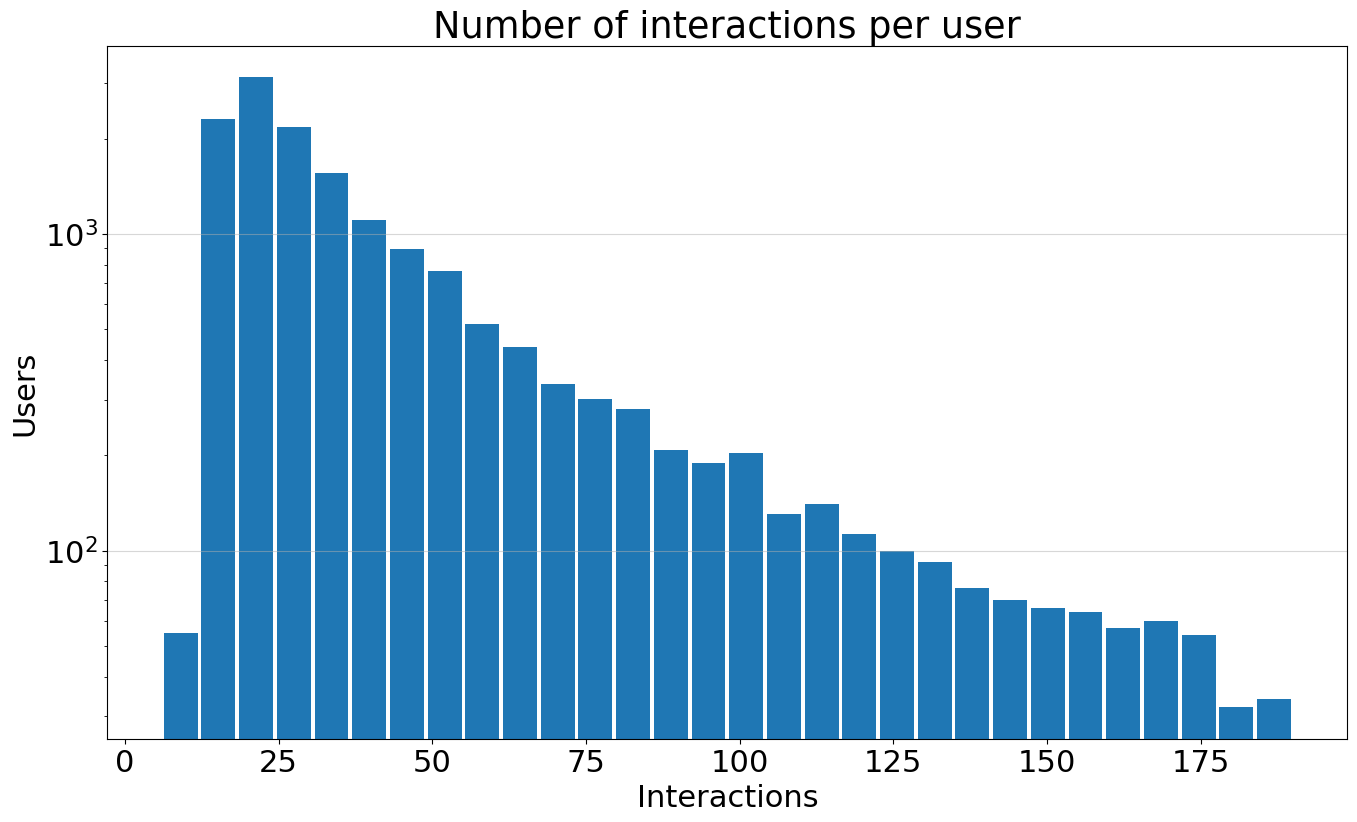

In [33]:
print("Interactions distribution per user:")
plot_interactions_distribution(interactions_per_user, "user", "Users")

Interactions distribution per item:


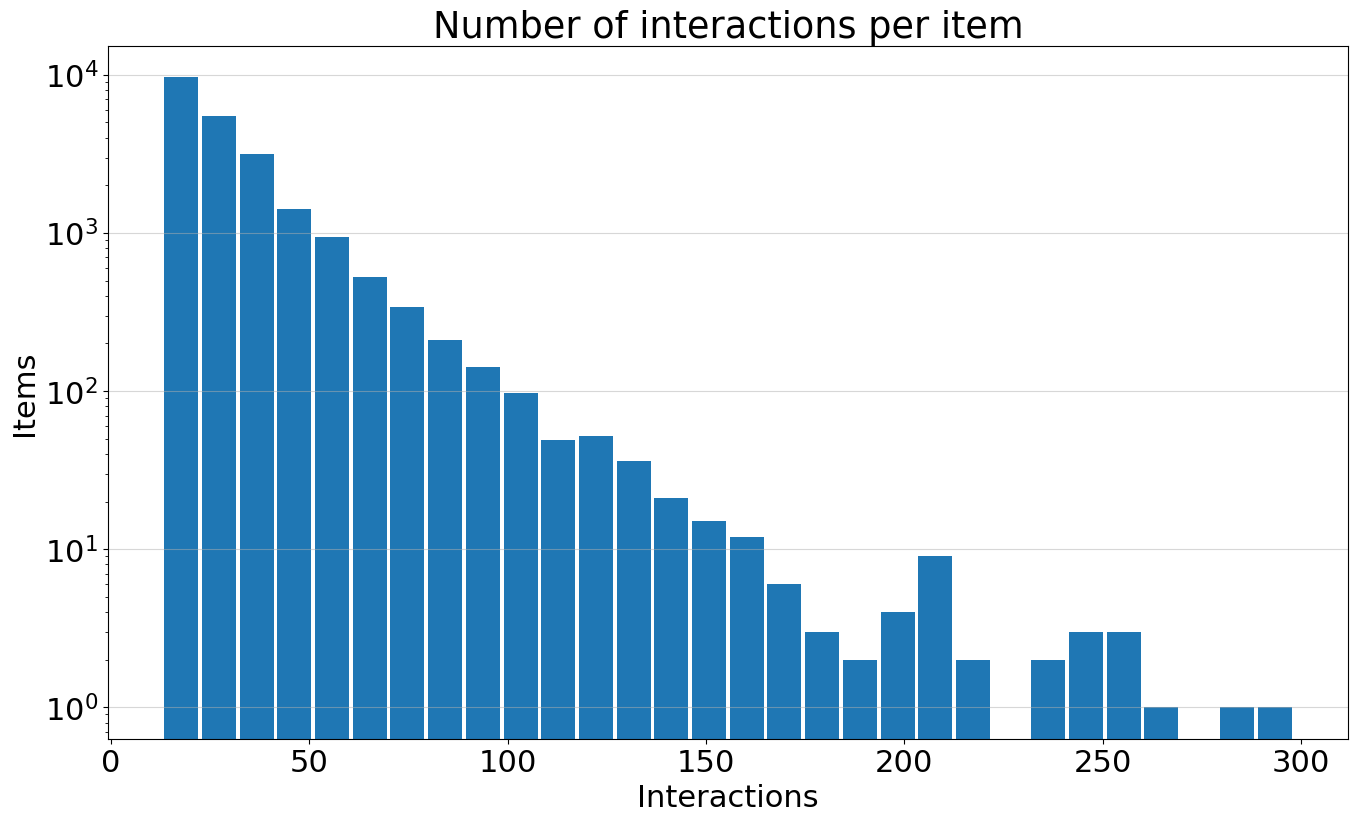

In [34]:
print("Interactions distribution per item:")
plot_interactions_distribution(interactions_per_item, "item", "Items")

## Interakcje w czasie

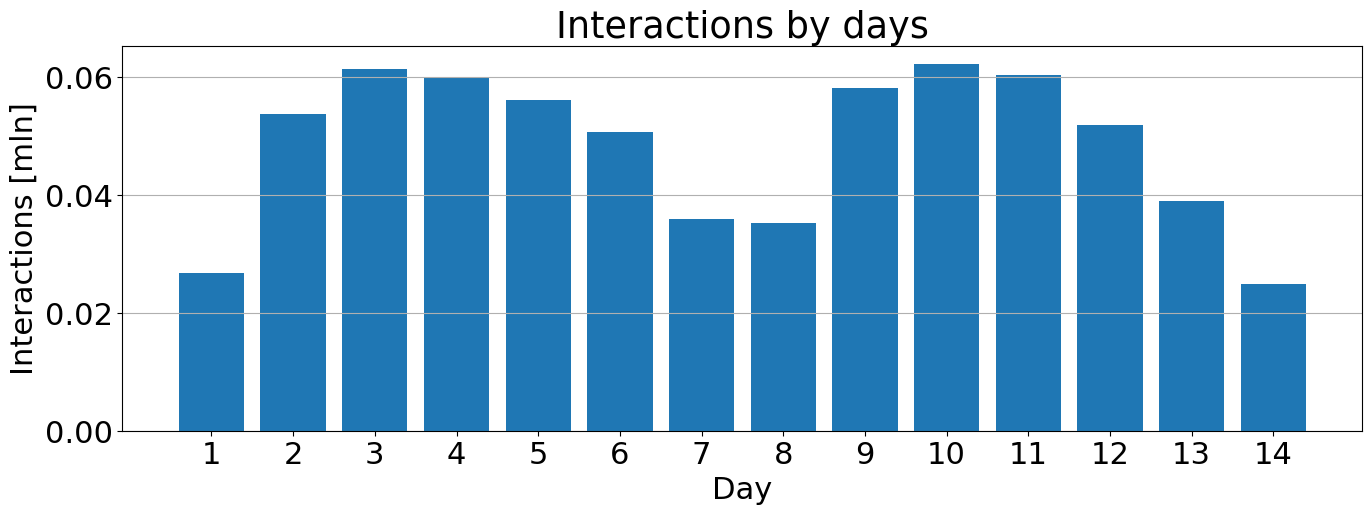

In [35]:
def unix_to_day(timestamps):
    min_timestamp = timestamps.min()
    seconds_in_day = 60*60*24
    return (timestamps - min_timestamp) // seconds_in_day + 1

def plot_interactions_over_time(series):
    freq = series.value_counts()
    labels, counts = freq.index, freq.values/10**6
    
    matplotlib.rcParams.update({"font.size": 22})
    plt.figure(figsize=(16,5))
    plt.bar(labels, counts, align='center')
    plt.gca().set_xticks(labels)
    plt.title(f"Interactions by days")
    plt.xlabel("Day")
    plt.ylabel("Interactions [mln]")
    plt.grid(axis="y")

plot_interactions_over_time(unix_to_day(df1["timestamp"]))

## Rozkład eventów

In [36]:
dataframe_freq = interactions['event'].value_counts() / len(interactions)
df_freq = df1['event'].value_counts() / len(df1)

freq = {
    'full_dataset_freq': dataframe_freq.apply(lambda x: f"{100*x:.2f}%"),
    'sampled_dataset_freq': df_freq.apply(lambda x: f"{100*x:.2f}%")
}

pd.DataFrame(freq)

,full_dataset_freq,sampled_dataset_freq
event,,
bookmark,2.48%,2.85%
chat_click,2.15%,2.54%
click,89.79%,88.37%
contact_chat,1.47%,1.75%
contact_partner_click,0.72%,0.68%
contact_phone_click_1,2.60%,2.88%
contact_phone_click_2,0.69%,0.81%
contact_phone_click_3,0.11%,0.13%


# Sprawdzenie licznosci itemów 

In [37]:
ilosc_wystapien = df1['item'].value_counts()
ilosc_wystapien

item
145769    298
44153     288
171495    264
48981     257
77995     256
         ... 
50602      13
75682      13
165080     13
136323     13
79214      13
Name: count, Length: 22153, dtype: int64

In [39]:
d=df1['item'].nunique()
print("Ilość itemów: ", d)
c = df1['user'].nunique()
print("Ilość użytkowników: ",c)

Ilość itemów:  22153
Ilość użytkowników:  15567


## Zbiór Testowy i Treningowy


In [40]:
_unique_users = df1['user'].unique()
train_users, test_users = train_test_split(_unique_users, train_size=0.7, random_state=42)

#Treningowy 
df_train = df1.query('user in @train_users').copy()

# Testowy
df_test = df1.query('user in @test_users').copy()

In [41]:
df_train.shape

(475028, 4)

# Podział zbioru danych na część treningową i testową z uwzględnieniem *timestamp*

In [42]:
df_train['split_point'] = df_train.groupby('user')['timestamp'].transform(lambda x: x.quantile(0.7))
df_train['is_train_input'] = df_train['timestamp'] <= df_train['split_point']

train_input = df_train[df_train['is_train_input']
                       ].drop(columns=['split_point', 'is_train_input']).sort_values('user').reset_index()
train_output = df_train[~df_train['is_train_input']
                        ].drop(columns=['split_point', 'is_train_input']).sort_values('user').reset_index()

In [43]:
df_test['split_point'] = df_test.groupby('user')['timestamp'].transform(lambda x: x.quantile(0.7))
df_test['is_test_input'] = df_test['timestamp'] <= df_test['split_point']

test_input = df_test[df_test['is_test_input']
                       ].drop(columns=['split_point', 'is_test_input']).sort_values('user').reset_index()
test_output = df_test[~df_test['is_test_input']
                        ].drop(columns=['split_point', 'is_test_input']).sort_values('user').reset_index()

## Przekształcenie kolumny "EVENT".

In [44]:
kopia_train = df_train.copy()
kopia_test = df_test.copy()

In [45]:
# Przekształcenie kolumny 'event' na wartości liczbowe (np. 1 dla kliknięcia)
event_mapping = {
    'click': 3,
    'bookmark': 7,
    'chat_click': 10,
    'contact_phone_click_1': 10,
    'contact_partner_click': 10,
    'contact_phone_click_2': 15,
    'contact_phone_click_3': 15,
    'contact_chat': 15
}

train_input['event'] = train_input['event'].map(event_mapping)
train_output['event'] = train_output['event'].map(event_mapping)

test_input['event'] = test_input['event'].map(event_mapping)
test_output['event'] = test_output['event'].map(event_mapping)

In [46]:
# Przekształcenie kolumny 'event' na wartości liczbowe (np. 1 dla kliknięcia)
event_mapping = {
    'click': 3,
    'bookmark': 7,
    'chat_click': 10,
    'contact_phone_click_1': 10,
    'contact_partner_click': 10,
    'contact_phone_click_2': 15,
    'contact_phone_click_3': 15,
    'contact_chat': 15
}

kopia_train['event'] = kopia_train['event'].map(event_mapping)
kopia_test['event'] = kopia_test['event'].map(event_mapping)

## Model ALS 

**Algorytm naprzemiennych najmniejszych kwadratów** (ang. Alternating Least Squares,
ALS)

W systemach rekomendacji celem jest przewidywanie preferencji użytkownika na podstawie wcześniejszych zachowań lub podobieństw z innymi użytkownikami. Algorytm ALS osiąga to poprzez faktoryzację macierzy interakcji użytkownik-element (np. reakcja użytkownika na ogłoszenie) na dwie macierze o niższym wymiarze: jedną reprezentującą ukryte preferencje użytkownika, a drugą atrybuty elementu. Ta faktoryzacja dobrze radzi sobie z rzadkimi danymi, co jest częste w systemach rekomendacyjnych. w których większość interakcji użytkownik-element jest nieznana.

**Zalety:**
ALS jest idealny do przewidywania niejawnych danych oraz jest skalowalny dla dużych zestawów danych, co jest istotne w kontekście systemów rekomendacyjnych, algorytmy muszą być skalowalne, aby móc efektywnie generować rekomendacje dla dużej liczby użytkowników oraz elementów, a także dostosowywać się do dynamicznie zmieniających się preferencji użytkowników i nowych danych.



In [47]:
# pip install threadpoolctl
import threadpoolctl
threadpoolctl.threadpool_limits(1, "blas")

# Podejście 1

## Tworzymy macierze rzadkie

In [48]:
a = train_output.groupby(['user', 'item'])['event'].mean().unstack(fill_value=0)
b = train_input.groupby(['user', 'item'])['event'].mean().unstack(fill_value=0)
c = test_output.groupby(['user', 'item'])['event'].mean().unstack(fill_value=0)
d = test_input.groupby(['user', 'item'])['event'].mean().unstack(fill_value=0)

f = kopia_train.groupby(['user', 'item'])['event'].mean().unstack(fill_value=0)
g = kopia_test.groupby(['user', 'item'])['event'].mean().unstack(fill_value=0)

## Konwertowanie danych na macierz CSR (Compressed Sparse Row)


Macierz rzadka jest szczególnym przypadkiem macierzy, w której liczba elementów zerowych jest znacznie wyższa niż liczba elementów niezerowych. Zasadniczo, jeśli 2/3 wszystkich elementów macierzy to zera, można ją nazwać macierzą rzadką.

W macierzy reprezentujemy użytkowników jako wiersze oraz ogłoszenia jako kolumny.

## CSR

In [49]:
user_items_train_output = csr_matrix(a.values,dtype=np.float64)
user_items_train_input = csr_matrix(b.values,dtype=np.float64)

user_items_test_output = csr_matrix(c.values,dtype=np.float64)
user_items_test_input = csr_matrix(d.values,dtype=np.float64)


user_items_train = csr_matrix(f.values,dtype=np.float64)
user_items_test= csr_matrix(g.values,dtype=np.float64)

## Model ALS 

In [50]:
# Inicjalizacja modelu ALS
model = AlternatingLeastSquares(factors=100)
model.fit(user_items_train)

  0%|          | 0/15 [00:00<?, ?it/s]

# Metryki

In [51]:
precision = implicit.evaluation.precision_at_k(model, user_items_train, user_items_test, K=10, show_progress=True, num_threads=1)
precision

  0%|          | 0/4671 [00:00<?, ?it/s]

0.0014303051317614425

In [52]:
ndcg = implicit.evaluation.ndcg_at_k(model, user_items_train, user_items_test, K=10, show_progress=True, num_threads=1)
ndcg

  0%|          | 0/4671 [00:00<?, ?it/s]

0.0015025284062885693

In [53]:
# Definiujemy wartość K, czyli liczbę rekomendacji do uwzględnienia w recall.
K = 10

# Obliczamy rekomendacje za pomocą Twojego modelu
recommendations = model.recommend_all(user_items_test, N=K)

# Inicjalizujemy licznik trafień i liczbę wszystkich pozytywnych przypadków
hits = 0
total_positives = 0

# Iterujemy po użytkownikach
for user_id in range(user_items_test_output.shape[0]):
    # Pobieramy indeksy pozytywnych elementów dla użytkownika w zbiorze testowym
    true_positives = user_items_test_output[user_id].indices
    # Pobieramy indeksy polecanych elementów dla użytkownika
    recommended_items = recommendations[user_id]

    # Zliczamy ile z polecanych elementów znajduje się w rzeczywistych pozytywnych
    hits += len(set(true_positives) & set(recommended_items))
    # Zliczamy wszystkie pozytywne przypadki
    total_positives += len(true_positives)

# Obliczamy recall
recall = hits / total_positives

print(hits)
print(total_positives)
print("Recall@{}: {:.2f}".format(K, recall))

30
46798
Recall@10: 0.00


In [54]:
K = 10

# Obliczamy rekomendacje za pomocą modelu
recommendations = model.recommend_all(user_items_test, N=K)

# Inicjalizujemy licznik trafień i liczbę wszystkich polecanych elementów
hits = 0
total_recommendations = 0

# Iterujemy po użytkownikach
for user_id in range(user_items_test_output.shape[0]):
    # Pobieramy indeksy pozytywnych elementów dla użytkownika w zbiorze testowym
    true_positives = user_items_test_output[user_id].indices
    # Pobieramy indeksy polecanych elementów dla użytkownika
    recommended_items = recommendations[user_id]

    # Zliczamy ile z polecanych elementów znajduje się w rzeczywistych pozytywnych
    hits += len(set(true_positives) & set(recommended_items))
    # Zliczamy wszystkie polecane elementy
    total_recommendations += len(recommended_items)

# Obliczamy precyzję
precision = hits / total_recommendations


print(hits)
print(total_recommendations)
print("Precision@{}: {:.2f}".format(K, precision))

30
46710
Precision@10: 0.00


# Podejście 2

In [55]:
test_pivot_table = kopia_test.groupby(['user', 'item'])['event'].mean().unstack(fill_value=0)

In [56]:
train_pivot_table = kopia_train.groupby(['user', 'item'])['event'].mean().unstack(fill_value=0)

In [57]:
user_items_train = csr_matrix(train_pivot_table.values,dtype=np.float64)
user_items_test= csr_matrix(test_pivot_table.values,dtype=np.float64)

In [58]:
# Inicjalizacja modelu ALS
model = AlternatingLeastSquares(factors=100)
model.fit(user_items_train)

  0%|          | 0/15 [00:00<?, ?it/s]

In [59]:
recs = model.recommend(5, user_items_test[5], N=5)
print(recs)

(array([11338, 17469,  9964,  3446,  4775]), array([0.3858102 , 0.3613174 , 0.34952986, 0.32981434, 0.29898137],
      dtype=float32))


In [60]:
precision = implicit.evaluation.precision_at_k(model, user_items_train, user_items_test, K=10, show_progress=True, num_threads=1)
precision

  0%|          | 0/4671 [00:00<?, ?it/s]

0.0014303051317614425

In [61]:
ndcg = implicit.evaluation.ndcg_at_k(model, user_items_train, user_items_test, K=10, show_progress=True, num_threads=1)
ndcg

  0%|          | 0/4671 [00:00<?, ?it/s]

0.0014761606089347189

# Podejście 3 

## Transformacja zbioru danych

In [62]:
df1['label'] = df1['event'].map(event_mapping)

C:\Users\Julka_uczelnia\AppData\Local\Temp\ipykernel_21572\1737201357.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['label'] = df1['event'].map(event_mapping)


In [63]:
train_data, eval_data, test_data = random_split(df1, multi_ratios=[0.7, 0.1, 0.2], seed=42)
train_data, data_info = DatasetPure.build_trainset(train_data)
eval_data = DatasetPure.build_evalset(eval_data)
test_data = DatasetPure.build_testset(test_data)
print(data_info)

n_users: 15567, n_items: 22153, data density: 0.1372 %


## Model

In [64]:
als = ALS(
    "ranking",
    data_info,
    embed_size=16,
    n_epochs=2,
    reg=5.0,
    alpha=10,
    use_cg=False,
    n_threads=1,
    seed=42,
)
als.fit(
    train_data,
    neg_sampling=True,
    verbose=2,
    eval_data=eval_data,
    metrics=["precision", "recall", "ndcg"],
)

Training start time: 2024-03-07 12:01:41
Epoch 1 elapsed: 0.528s


eval_listwise: 100%|██████████| 14611/14611 [00:22<00:00, 640.09it/s]


	 eval precision@10: 0.0009
	 eval recall@10: 0.0022
	 eval ndcg@10: 0.0041
Epoch 2 elapsed: 0.507s


eval_listwise: 100%|██████████| 14611/14611 [00:21<00:00, 677.96it/s]


	 eval precision@10: 0.0103
	 eval recall@10: 0.0256
	 eval ndcg@10: 0.0472


## Metryki

In [65]:
evaluate(
    model=als, 
    data=test_data, 
    neg_sampling=True,  # perform negative sampling on test data
    metrics=["loss", "roc_auc", "precision", "recall", "ndcg"],
)

eval_pointwise: 100%|██████████| 34/34 [00:00<00:00, 227.28it/s]
c:\Users\Julka_uczelnia\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:2845: FutureWarning: Setting the eps parameter is deprecated and will be removed in 1.5. Instead eps will always havea default value of `np.finfo(y_pred.dtype).eps`.
  warnings.warn(
eval_listwise: 100%|██████████| 15475/15475 [00:23<00:00, 644.79it/s]


{'loss': 0.6476190842203097,
 'roc_auc': 0.8420681250689526,
 'precision': 0.01827463651050081,
 'recall': 0.025651919205665594,
 'ndcg': 0.08032170990515564}